C:\Users\redwan.khafif\AppData\Local\Temp\ipykernel_20156\3943659383.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(start="2023-01-01", periods=minutes, freq=FREQ)


Total Return sur 7 jours = 303.48 %
Sharpe Ratio annualisé estimé = 11.61
Max Drawdown = 38.49 %
Nombre de trades = 11


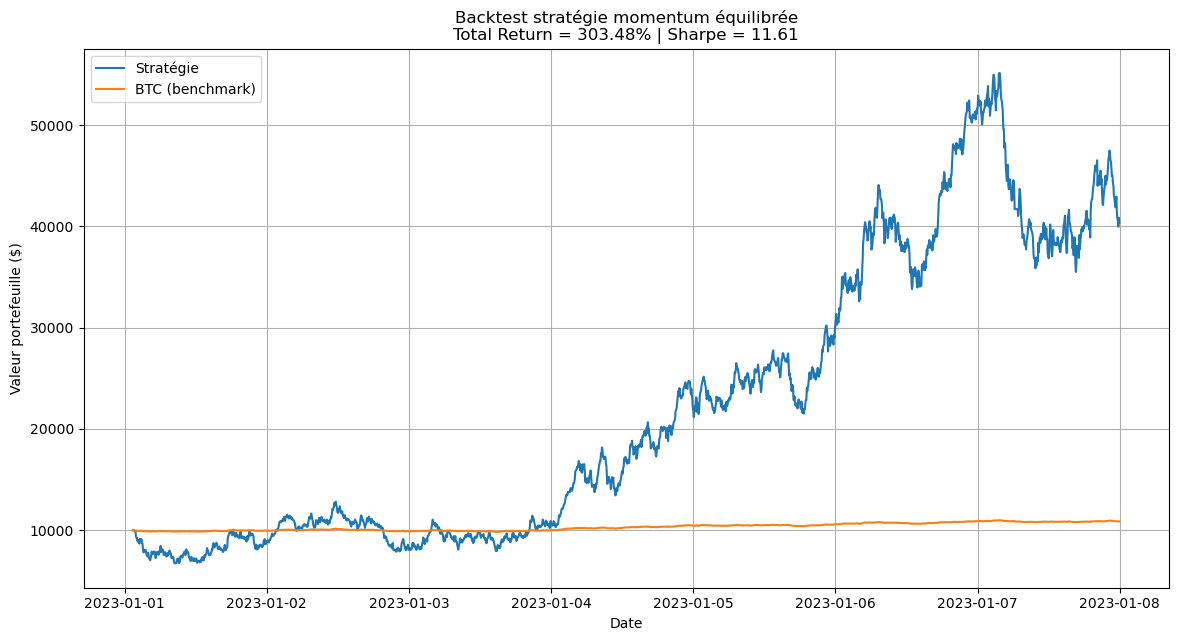

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Paramètres
np.random.seed(42)
DAYS = 7
FREQ = "5T"  # données toutes les 5 minutes
INITIAL_CAPITAL = 10000.0

# Génération données synthétiques BTC et ETH
minutes = DAYS * 24 * 12  # 12 données par heure (5 minutes)
dates = pd.date_range(start="2023-01-01", periods=minutes, freq=FREQ)

btc_sigma = 0.001
btc_r = np.random.normal(0, btc_sigma, minutes)
btc_price0 = 30000
btc_prices = btc_price0 * np.exp(np.cumsum(btc_r))

eth_beta_to_btc = 0.8
eth_noise_sigma = 0.0012
eth_r = eth_beta_to_btc * btc_r + np.random.normal(0, eth_noise_sigma, minutes) * (1 - eth_beta_to_btc)
eth_price0 = 1800
eth_prices = eth_price0 * np.exp(np.cumsum(eth_r))

df = pd.DataFrame({"BTC": btc_prices, "ETH": eth_prices}, index=dates)

# Indicateurs
ATR_LEN = 14
df["log_ETH"] = np.log(df["ETH"])
df["log_diff"] = df["log_ETH"].diff().abs()
df["ATR"] = df["log_diff"].rolling(ATR_LEN, min_periods=1).mean()
df["momentum"] = df["ETH"].pct_change(3)  # momentum court terme 15 minutes (3 * 5min)

# Paramètres stratégie
RISK_PER_TRADE = 0.02     # 2% du capital par trade
STOP_LOSS_PCT = 0.01      # 1% stop loss
TAKE_PROFIT_PCT = 0.03    # 3% take profit

capital = INITIAL_CAPITAL
position = 0
entry_price = 0
equity = []
trade_log = []

for i in range(ATR_LEN+3, len(df)):
    price = df["ETH"].iloc[i]
    atr = df["ATR"].iloc[i]
    mom = df["momentum"].iloc[i]

    # Taille position basée sur ATR et risque par trade
    if atr > 0:
        dollar_risk_per_unit = price * atr
        units = (capital * RISK_PER_TRADE) / dollar_risk_per_unit
    else:
        units = 0

    # Signal d'achat si momentum positif et pas déjà en position
    if mom > 0 and position == 0 and units > 0:
        position = units
        entry_price = price
        capital -= units * price
        trade_log.append(("BUY", df.index[i], units, price))

    # En position, check SL / TP
    if position > 0:
        pnl_pct = (price - entry_price) / entry_price
        if pnl_pct <= -STOP_LOSS_PCT or pnl_pct >= TAKE_PROFIT_PCT:
            capital += position * price
            side = "SELL (TP)" if pnl_pct >= TAKE_PROFIT_PCT else "SELL (SL)"
            trade_log.append((side, df.index[i], position, price))
            position = 0
            entry_price = 0

    # Valeur portefeuille
    port_value = capital + (position * price if position > 0 else 0)
    equity.append(port_value)

equity_series = pd.Series(equity, index=df.index[ATR_LEN+3:])

# Metrics
total_return = (equity_series.iloc[-1] / INITIAL_CAPITAL - 1) * 100
returns = equity_series.pct_change().dropna()
sharpe = (returns.mean() / returns.std()) * np.sqrt(252*24*12)  # annualisé approx
max_drawdown = ((equity_series.cummax() - equity_series) / equity_series.cummax()).max() * 100

# Affichage résultats
print(f"Total Return sur {DAYS} jours = {total_return:.2f} %")
print(f"Sharpe Ratio annualisé estimé = {sharpe:.2f}")
print(f"Max Drawdown = {max_drawdown:.2f} %")
print(f"Nombre de trades = {len(trade_log)}")

# Graphique
btc_nav = (df["BTC"] / df["BTC"].iloc[0]) * INITIAL_CAPITAL
btc_nav = btc_nav.reindex(equity_series.index).ffill()

plt.figure(figsize=(14,7))
plt.plot(equity_series, label="Stratégie")
plt.plot(btc_nav, label="BTC (benchmark)")
plt.title(f"Backtest stratégie momentum équilibrée\nTotal Return = {total_return:.2f}% | Sharpe = {sharpe:.2f}")
plt.xlabel("Date")
plt.ylabel("Valeur portefeuille ($)")
plt.legend()
plt.grid(True)
plt.show()
